<a href="https://colab.research.google.com/github/compressed-sensing/algorithms/blob/development/CS_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import scipy.signal as signal
from scipy.signal import convolve2d
import scipy.fft as fft
import urllib.request
from skimage.metrics import peak_signal_noise_ratio as PSNR
import time
np.random.seed(30)

# Import image

In [ ]:
%%shell
mkdir data
wget https://zenodo.org/record/3677090/files/0219191_mystudy-0219-1114.tar.gz -O data/mystudy.tar.gz
mkdir data/dicom_examples
tar -xvzf data/mystudy.tar.gz -C data/dicom_examples
gzip -d data/dicom_examples/0219191_mystudy-0219-1114/dcm/*dcm.gz
mkdir -p data/dicom_examples/nii
sudo apt-get install dcm2niix
pip install nibabel


--2023-05-10 23:09:27--  https://zenodo.org/record/3677090/files/0219191_mystudy-0219-1114.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405671662 (387M) [application/octet-stream]
Saving to: ‘data/mystudy.tar.gz’

data/mystudy.tar.gz 100%[===================>] 386.88M  29.2MB/s    in 15s     

2023-05-10 23:09:44 (25.8 MB/s) - ‘data/mystudy.tar.gz’ saved [405671662/405671662]

0219191_mystudy-0219-1114/
0219191_mystudy-0219-1114/.DS_Store
0219191_mystudy-0219-1114/gzip-report.log
0219191_mystudy-0219-1114/TransferStatus.log
0219191_mystudy-0219-1114/dcm/
0219191_mystudy-0219-1114/dcm/12-320-1.dcm.gz
0219191_mystudy-0219-1114/dcm/11-118-1.dcm.gz
0219191_mystudy-0219-1114/dcm/7-5-1.dcm.gz
0219191_mystudy-0219-1114/dcm/5-32-1.dcm.gz
0219191_mystudy-0219-1114/dcm/9-188-1.dcm.gz
0219191_mystudy-0219-1114/dcm/12-393-1.dcm.gz
0219191_mystudy-0219-1114/dc

In [ ]:
!dcm2niix -z y -o data/dicom_examples/nii data/dicom_examples/0219191_mystudy-0219-1114/

Compression will be faster with 'pigz' installed
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 2661 DICOM file(s)
slices stacked despite varying acquisition numbers (if this is not desired recompile with 'mySegmentByAcq')
Convert 485 DICOM as data/dicom_examples/nii/0219191_mystudy-0219-1114_func_ses-01_task-story_run-03_20190219111436_11 (64x64x27x485)
Convert 128 DICOM as data/dicom_examples/nii/0219191_mystudy-0219-1114_anat_ses-01_scout_20190219111436_1 (160x160x128x1)
Convert 485 DICOM as data/dicom_examples/nii/0219191_mystudy-0219-1114_func_ses-01_task-story_run-02_20190219111436_10 (64x64x27x485)
Convert 485 DICOM as data/dicom_examples/nii/0219191_mystudy-0219-1114_func_ses-01_task-story_run-04_20190219111436_12 (64x64x27x485)
Convert 192 DICOM as data/dicom_examples/nii/0219191_mystudy-0219-1114_anat_ses-01_T1w_20190219111436_5 (256x256x192x1)
Convert 485 DICOM as data/dicom_examples/nii/0219191_mystudy-0219-1114_func_ses-01_task-

In [ ]:
import nibabel as nib

In [ ]:
file_path="data/dicom_examples/nii/0219191_mystudy-0219-1114_anat_ses-01_T1w_20190219111436_5.nii.gz"
#file_path="/content/data/dicom_examples/nii/0219191_mystudy-0219-1114_anat_ses-01_scout_20190219111436_2_i00001.nii.gz"

t1_img = nib.load(file_path)

In [ ]:
t1_data = t1_img.get_fdata()

In [ ]:
x_slice = t1_data[9, :, :]
y_slice = t1_data[:, 19, :]
z_slice = t1_data[:, :, 2]

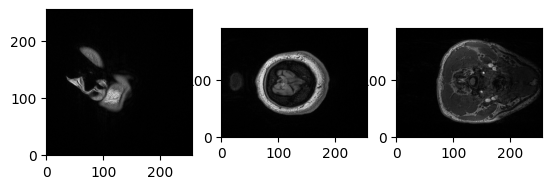

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, slice in enumerate(slices):
    axes[i].imshow(slice, cmap="gray", origin="lower")

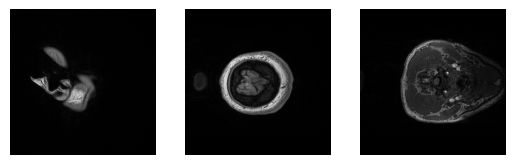

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming x_slice, y_slice, and z_slice are the input images

slices = [x_slice, y_slice, z_slice]

# Find the maximum dimension among all images
max_dim = max([slice.shape[0] for slice in slices] + [slice.shape[1] for slice in slices])

# Create a new list to store the padded images
padded_slices = []

# Pad zeros to make each image square
for slice in slices:
    height_diff = max_dim - slice.shape[0]
    width_diff = max_dim - slice.shape[1]
    pad_top = height_diff // 2
    pad_bottom = height_diff - pad_top
    pad_left = width_diff // 2
    pad_right = width_diff - pad_left
    padded_slice = np.pad(slice, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')
    padded_slices.append(padded_slice)

# Plot the padded images
fig, axes = plt.subplots(1, len(padded_slices))
for i, slice in enumerate(padded_slices):
    axes[i].imshow(slice, cmap="gray", origin="lower")
for ax in axes.ravel():
  ax.axis('off')


# Define conv and fft functions

In [ ]:
print(x_slice.shape)

(256, 256)


In [ ]:
np.min(x_slice)

0.0

In [ ]:
np.max(x_slice)

1237.0

In [ ]:
type(x_slice[0][0])

numpy.float64

In [ ]:
def to_fourier_domain(x):
  return fft.fftshift(fft.fft2(fft.ifftshift(x)))

def to_image_domain(x):
  return fft.ifftshift(fft.ifft2(fft.fftshift(x)))

In [ ]:
# Define some of the operators that we need...
def conv2d_fft(x, h):
     p0 = x.shape[0]-h.shape[0]
     p1 = x.shape[1]-h.shape[1]
     h_pad = np.pad(h, ((p0//2,p0//2),(p1//2,p1//2)))
     Fh = to_fourier_domain(h_pad)
     Fx = to_fourier_domain(x)
     return to_image_domain(Fx*Fh)

def conv2dT_fft(x, h):
     p0 = x.shape[0]-h.shape[0]
     p1 = x.shape[1]-h.shape[1]
     h_pad = np.pad(h, ((p0//2,p0//2),(p1//2,p1//2)))
     Fh = to_fourier_domain(h_pad)
     Fx = to_fourier_domain(x)
     return to_image_domain(Fx*np.conj(Fh))

# Create the binary mask
According to FastMRI paper

In [ ]:

def generate_random_mask(img_shape, center_percentage=8):
    mask = np.zeros(img_shape)
    center_columns = int(img_shape[1] * center_percentage / 100)
    center_start = int(img_shape[1] / 2) - int(center_columns / 2)
    center_end = center_start + center_columns
    
    for col in range(center_start, center_end):
        mask[:, col] = 1
    
    num_random_cols = int(0.25 * img_shape[1])
    random_cols = np.random.choice([i for i in range(img_shape[1]) if i < center_start or i >= center_end], num_random_cols, replace=False)
    
    for col in random_cols:
        mask[:, col] = 1
    
    return mask.astype(int)


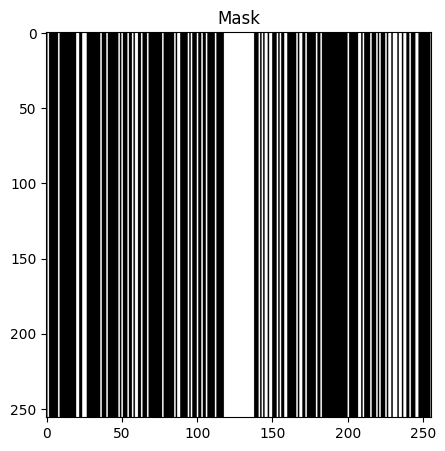

In [ ]:
rmask = generate_random_mask(x_slice.shape)  # generate a 100x100 mask with 30% center columns
# plot mask and mask_fft together
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.imshow(rmask, cmap='gray')
axs.set_title('Mask')
plt.show()

In [ ]:
# assuming img_shape to be square, shape is of type (x,x) -> (512,512)
def generate_equidistant_mask(img_shape, acceleration_factor=4, center_percentage=25):
  mask = np.zeros(img_shape, dtype=np.float32)
  mask[::acceleration_factor] = 1.0

  # Set center_percentage% of the center lines to all ones
  fraction = 100//center_percentage
  center_lines = img_shape[0] // fraction
  start = (img_shape[0] - center_lines) // 2
  end = start + center_lines
  mask[start:end] = 1.0
  return mask.T

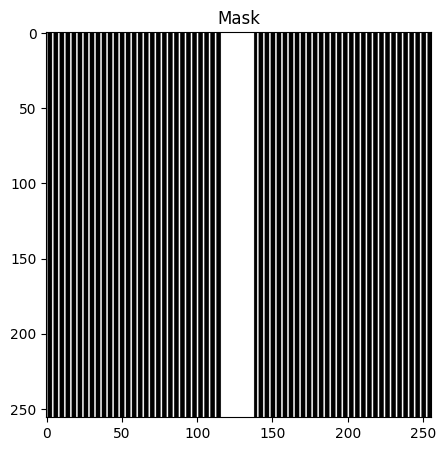

In [ ]:
eq_mask = generate_equidistant_mask(x.T.shape, acceleration_factor=4, center_percentage=8)
# plot mask and mask_fft together
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.imshow(eq_mask, cmap='gray')
axs.set_title('Mask')
plt.show()

In [ ]:
def get_log_spectrum(fft_data):
  return 20*np.log(np.abs(fft_data) + 1)

In [ ]:
# Input image for processing
x = padded_slices[2]
# Equidistant Mask
eq_mask = generate_equidistant_mask(x.T.shape, acceleration_factor=4, center_percentage=8)
# Random Mask
rmask = generate_random_mask(x.shape) 

# Computing ploting parameters
def param(x, mask):
  spectrum_image = to_fourier_domain(x.T)
  masked_spectrum = spectrum_image*mask
  zero_filled_ifft = to_image_domain(masked_spectrum*mask)
  return spectrum_image, masked_spectrum, zero_filled_ifft

# Computing parameters for random mask and equidistant mask
spectrum_image, masked_spectrum, zero_filled_ifft = param(x, eq_mask)
spectrum_image_r, masked_spectrum_r, zero_filled_ifft_r = param(x,rmask)

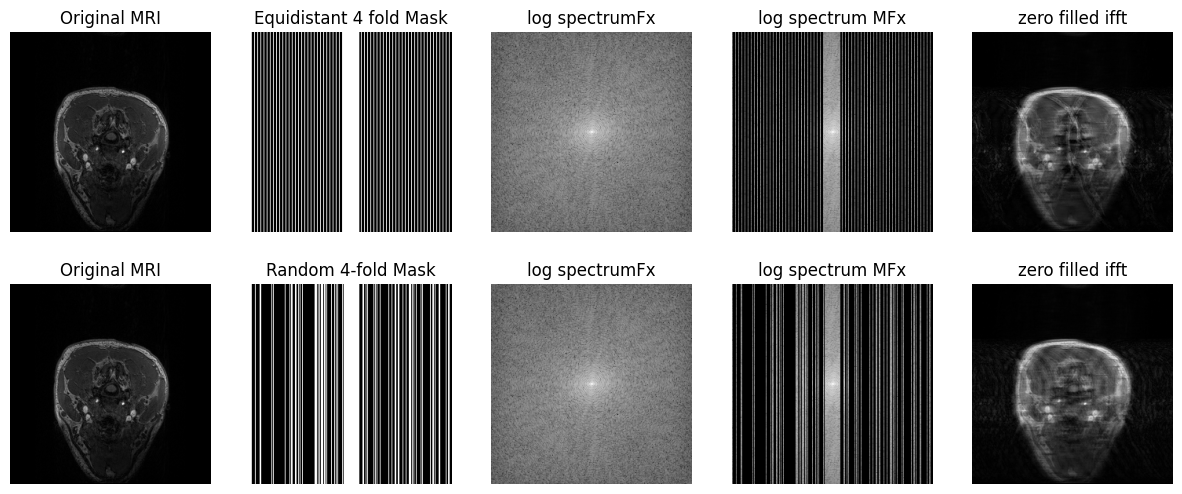

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs[0,0].imshow(x.T, cmap='gray')
axs[0,0].set_title('Original MRI')
axs[0,1].imshow(eq_mask, cmap='gray')
axs[0,1].set_title('Equidistant 4 fold Mask')
axs[0,2].imshow(get_log_spectrum(spectrum_image), cmap='gray')
axs[0,2].set_title('log spectrumFx')
axs[0,3].imshow(get_log_spectrum(masked_spectrum), cmap='gray')
axs[0,3].set_title('log spectrum MFx')
axs[0,4].imshow(np.abs(zero_filled_ifft), cmap='gray')
axs[0,4].set_title('zero filled ifft')
axs[1,0].imshow(x.T, cmap='gray')
axs[1,0].set_title('Original MRI')
axs[1,1].imshow(rmask, cmap='gray')
axs[1,1].set_title('Random 4-fold Mask')
axs[1,2].imshow(get_log_spectrum(spectrum_image_r), cmap='gray')
axs[1,2].set_title('log spectrumFx')
axs[1,3].imshow(get_log_spectrum(masked_spectrum_r), cmap='gray')
axs[1,3].set_title('log spectrum MFx')
axs[1,4].imshow(np.abs(zero_filled_ifft_r), cmap='gray')
axs[1,4].set_title('zero filled ifft')
for ax in axs.ravel():
  ax.axis('off')
plt.show()

# Gradiant operator

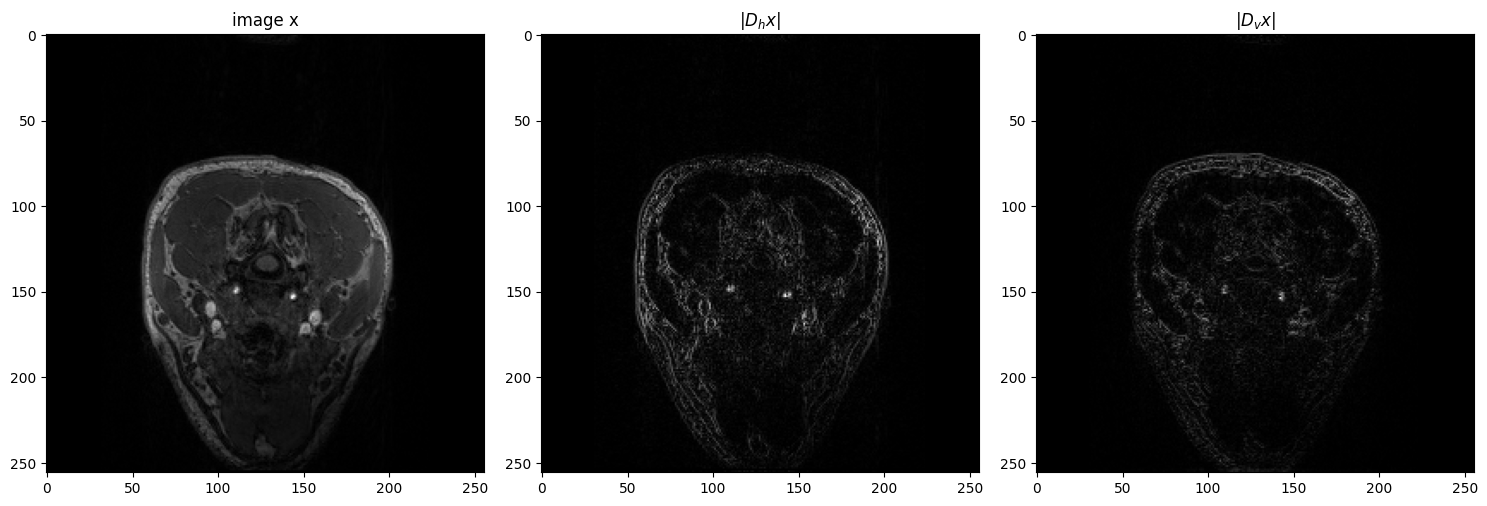

In [ ]:
# define gradient operators
'''
I am testing it with y1 for now
'''
dh = np.array([[1,-1],[0, 0]]) # horizontal gradient filter
dv = np.array([[1, 0],[-1,0]]) # vertical gradient filter

Dh = lambda x: conv2d_fft(x, dh)
Dv = lambda x: conv2d_fft(x, dv)

DhT = lambda x: conv2dT_fft(x, dh)
DvT = lambda x: conv2dT_fft(x, dv)

# plot the image x and the gradient images Dh x and Dv x
fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(x.T, cmap='gray')
plt.title('image x')
plt.subplot(132)
plt.imshow(np.abs(Dh(x.T)), cmap='gray')
plt.title(r'$|D_hx|$')
plt.subplot(133)
plt.imshow(np.abs(Dv(x.T)), cmap='gray')
plt.title(r'$|D_vx|$')
plt.tight_layout()
plt.show()

# TV Primal Dual
TV Compress Sensing MRI using Primal Dual

In [ ]:
def TV_MRI(MFx, M, lamb = 2, maxiter=50, tol=1e-4):
  '''
    TV-Compress Senssing MRI solver to solve
    minimize 0.5 |z-Hx|_2^2 + lambda|Dx|_1
    z : reconstructed img in each update
    x : original image
    Hx: masked image
  '''
  start = time.time()
  # define the soft-thresholding function
  soft_thresh = lambda v, t: np.maximum(np.abs(v)-t, 0.)*np.sign(v)

  # set step-sizes at maximum: τσL² < 1
  # note: PDS seems sensitive to these (given finite iterations at least...)
  L = np.sqrt(8) # Spectral norm of D
  tao = 0.99 / L
  sigma = 0.99 / L

  # Defining Prox functions
  '''
  z^k+1 = prox_tg(z^k-tD^Ty^k) 
  y^k+1 = prox_sigmaf*(y^k+sigmaDx^k+1)
  '''
  # Proximal Gradient Descent on x (primal)
  prox_D = lambda v,z: to_image_domain((to_fourier_domain(v)+tao*z)/(1+tao*M))
  # Proximal Gradient Ascent on z (dual)
  # prox_A = lambda v: (v - sigma*soft_thresh(v/sigma, lamb/sigma))
  prox_A = lambda v : np.clip(v, -lamb, lamb)

  # -----------------------------
  # initilize iteration variables
  z_hat = np.zeros_like(MFx)
  yh_hat = np.zeros_like(MFx)
  yv_hat = np.zeros_like(MFx)
  # For computing error
  J = np.zeros(maxiter)

  # Iterations
  k = 0
  while k < maxiter:
    # Update x - ProxD
    z_old = z_hat
    z_hat = prox_D(z_hat - tao*(DhT(yh_hat) + DvT(yv_hat)), MFx)
    # Update y - ProxA
    yh_hat = prox_A(yh_hat + sigma*(Dh(2*z_hat - z_old)))
    yv_hat = prox_A(yv_hat + sigma*(Dv(2*z_hat - z_old)))
    # compute the convergence

    # dual_h = Dh(z_hat) - yh_hat
    # dual_v = Dv(z_hat) - yv_hat
    # J[k] = (dual_h**2).sum()+(dual_v**2).sum()
    J[k] = np.abs(z_hat - z_old).sum()
    if J[k] < tol:
      break
    k=k+1

  end = time.time()
  return z_hat, J, end-start

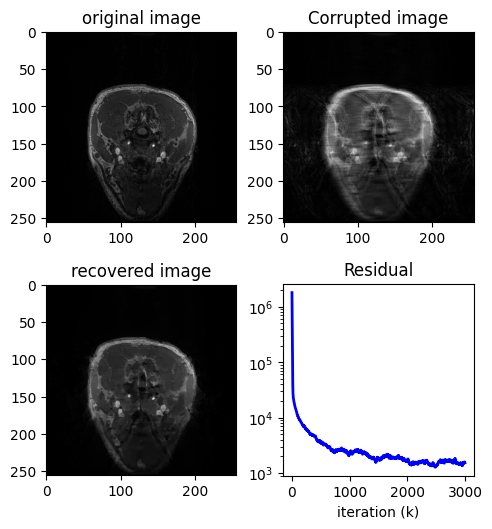

Time taken = 61.68910574913025


In [ ]:
x_t, j, duration1 = TV_MRI(masked_spectrum, eq_mask, lamb =5, maxiter=3000, tol=1e-2)
x_t_ifft = to_image_domain(x_t)
fig = plt.figure()
fig.set_size_inches(5,7.5)
ax = fig.add_subplot(321)
ax.imshow(x.T, cmap='gray')
plt.title('original image')
ax2 = fig.add_subplot(322)
ax2.imshow(np.abs(zero_filled_ifft), cmap='gray')
plt.title('Corrupted image')
ax3 = fig.add_subplot(323)
ax3.imshow(np.abs(x_t), cmap='gray')
plt.title('recovered image')
ax4 = fig.add_subplot(324)
ax4.semilogy(range(len(j)), j, 'b-', lw=2)
plt.title('Residual')
plt.xlabel('iteration (k)')
plt.tight_layout()
plt.show()
print(f"Time taken = {duration1}")

In [ ]:
PSNR(x.T, np.abs(zero_filled_ifft), data_range=np.max(np.abs(x)))

28.910346296010466

In [ ]:
PSNR(x.T, np.abs(x_t),data_range=np.max(np.abs(x)))

31.947600604929

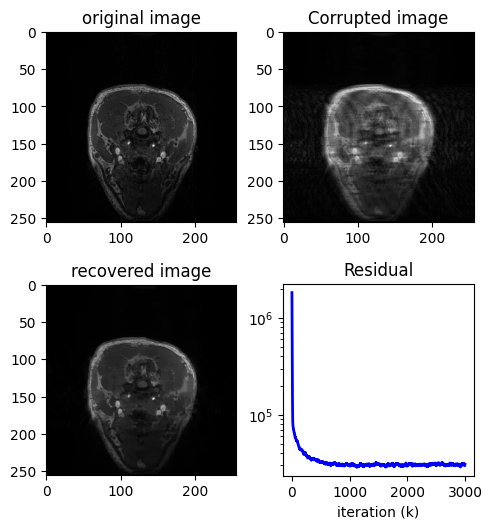

Time taken = 63.62596130371094


In [ ]:
x_tr, jr, duration1r = TV_MRI(masked_spectrum_r, rmask, lamb =5, maxiter=3000, tol=1e-2)

fig = plt.figure()
fig.set_size_inches(5,7.5)
ax = fig.add_subplot(321)
ax.imshow(x.T, cmap='gray')
plt.title('original image')
ax2 = fig.add_subplot(322)
ax2.imshow(np.abs(zero_filled_ifft_r), cmap='gray')
plt.title('Corrupted image')
ax3 = fig.add_subplot(323)
ax3.imshow(np.abs(x_tr), cmap='gray')
plt.title('recovered image')
ax4 = fig.add_subplot(324)
ax4.semilogy(range(len(jr)), jr, 'b-', lw=2)
plt.title('Residual')
plt.xlabel('iteration (k)')
plt.tight_layout()
plt.show()
print(f"Time taken = {duration1r}")

In [ ]:
PSNR(x.T, np.abs(zero_filled_ifft_r), data_range=np.max(np.abs(x)))

29.30164780779011

In [ ]:
PSNR(x.T, np.abs(x_tr),data_range=np.max(np.abs(x)))

34.472194671053884

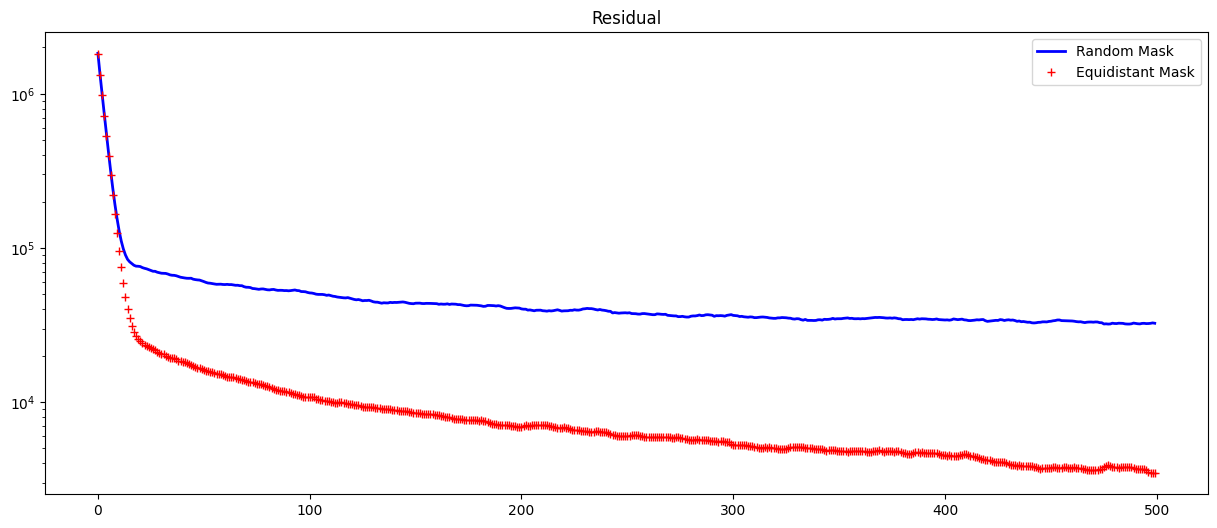

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15, 6))
axs.semilogy(range(len(jr)), jr, 'b-', lw=2, label = "Random Mask")
axs.semilogy(range(len(j)), j, 'r+', lw=2, label = "Equidistant Mask")
plt.title('Residual')
plt.legend()
